<img src="https://logodownload.org/wp-content/uploads/2015/02/ufmg-logo-2.png" alt="Logo UFMG" width="300px" align="left"><br><br>

# Explicação do Modelo

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: [Franco Naghetini](https://github.com/fnaghetini) e [Guilherme Silveira](https://github.com/guiasilveira)

Este notebook é dividido em apenas duas partes. Na Parte I, é realizada uma recaptulação de uma parte do fluxo apresentado no [segundo notebook](https://github.com/fnaghetini/Mapa-Preditivo/blob/main/2-predictive_litho_map.ipynb), visando reconstruir o modelo de melhor performance obtido, o *XGBoost*. Já na Parte II, é desenvolvida a interpretação desse modelo a partir da utilização do framework SHAP.

##  Configurações iniciais

### Importação de bibliotecas

Bibliotecas e funções utilizadas neste notebook. Leia a seção [Versões do Software](https://github.com/fnaghetini/Mapa-Preditivo) para conferir as versões das bibliotecas.

In [1]:
import numpy as np                                                   # operações numéricas
import pandas as pd                                                  # manipulação de dataframes e series
import matplotlib.pyplot as plt                                      # visualização dos dados

from functions.Custom_Train_Test_Split import customTrainTestSplit   # separação entre treino e teste
from sklearn.preprocessing import StandardScaler                     # escalonamento dos dados
from functions.Custom_Preprocessing import MaskedPCA                 # pca customizada
from imblearn.over_sampling import SMOTE                             # superamostragem

from xgboost import XGBClassifier                                    # xgboost

import shap                                                          # explicação do modelo
shap.initjs()

import warnings                                                      # desabilitar avisos
warnings.filterwarnings("ignore")

### Importação do banco de dados

In [2]:
df_original = pd.read_csv("data/data_nb3.csv",sep=",")
df = df_original.copy(deep = True)
df.head(10)

,X,Y,GT,K,TH,U,U_K,TH_K,U_TH,MDT,B02,B03,B04,B06,B07,TARGET,COD
0,638663.68,7981552.08,0.076001,0.38,3.98,2.21,3.11,6.51,0.49,1435.25,8673,8164,8288,15656,11371,6,PP4egm
1,638663.68,7981489.58,0.054137,0.41,3.66,2.44,3.11,6.91,0.47,1433.84,9071,8665,8944,17906,13743,6,PP4egm
2,638726.18,7981489.58,0.071591,0.57,5.30,2.63,2.72,6.97,0.41,1430.14,9036,8791,9117,17693,13716,6,PP4egm
3,638788.68,7981489.58,0.055794,0.80,7.26,2.88,2.40,7.16,0.36,1425.73,8862,8606,8891,16064,11973,6,PP4egm
4,638851.18,7981489.58,0.033372,1.05,9.20,3.17,2.21,7.50,0.33,1421.32,8742,8545,8667,15789,11648,6,PP4egm
5,638788.68,7981427.08,0.028260,0.85,6.60,2.97,2.51,7.64,0.36,1422.72,8705,8261,8287,15269,11403,6,PP4egm
6,638663.68,7981427.08,0.051313,0.44,3.20,2.62,3.14,7.37,0.44,1432.31,9347,8898,9163,18497,14848,6,PP4egm
7,638726.18,7981427.08,0.047716,0.62,4.74,2.80,2.80,7.47,0.40,1427.89,9016,8531,8604,16202,12264,6,PP4egm
8,638663.68,7981364.58,0.048052,0.49,2.99,2.77,3.18,7.87,0.42,1430.14,9285,8858,8972,17907,14332,6,PP4egm
9,638726.18,7981364.58,0.044078,0.64,4.20,2.87,2.87,7.93,0.38,1425.09,8904,8317,8311,15765,11898,6,PP4egm


## Separação entre treino e teste

In [3]:
FEAT  = ['GT','K','TH','U','U_K','TH_K','U_TH','MDT','B02','B03','B04','B06','B07']
COORD = ['X','Y']

In [4]:
X_train, y_train, X_test, y_test = customTrainTestSplit(df, FEAT, COORD, samp_per_class = 150, threshold = 0.7)

## Pré-processamento

### Escalonamento das features

In [5]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

### Redução da dimensionalidade

In [6]:
mask = np.arange(8,13)
pca = MaskedPCA(n_components = 1, mask = mask)
X_train_pca = pca.fit_transform(X_train_std)

In [7]:
# Aualização das features
FEAT = list(FEAT[:8] + ['PC1'])

### Superamostragem

In [8]:
smote = SMOTE()
X_train_smt, y_train_smt = smote.fit_resample(X_train_pca, y_train)

## Modelagem dos dados

In [9]:
clf = XGBClassifier(subsample = 0.9, reg_lambda = 0.001, min_child_weight = 5, eval_metric = 'mlogloss',
                    max_depth = 25, learning_rate = 0.3, gamma = 0.05, verbosity = 0,
                    eta = 0.025, colsample_bytree = 1.0, alpha = 0.1, random_state = 42)

clf.fit(X_train_smt, y_train_smt);

## Explicação do modelo

Recentemente, foram desenvolvidos métodos que auxiliam na interpretação das predições fornecidas por modelos complexos, tais como [LIME](https://github.com/marcotcr/lime), [DeepLIFT](https://github.com/kundajelab/deeplift) e [SHAP](https://github.com/slundberg/shap).

O **SHAP** é um framework unificado baseado na teoria dos jogos que assinala um valor de importância à cada feature para uma predição específica. Os valores de importância, denominados valores de Shapley, foram originalmente propostos por Shapley, na década de 1950, com o intuito de estimar a importância de cada jogador em uma equipe colaborativa.

In [10]:
X_train_with_col_names = pd.DataFrame(X_train_smt, columns=FEAT)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train_with_col_names)

In [11]:
dic_lith = {0 : 'MAcgg',
            1 : 'PP3csbg',
            2 : 'PP34b',
            3 : 'PP4esjc',
            4 : 'PP4esb',
            5 : 'PP4egm'}

### Impacto das variáveis nas predições

A *Figura 01* descreve a importância das variáveis independentes nas predições das classes realizadas pelo modelo *XGBoost*. O eixo vertical é representado pelas features, ao passo que o eixo horizontal representa a média dos valores de Shapley, de modo que as variáveis preditoras são apresentadas em ordem crescente de importância (de baixo para cima).

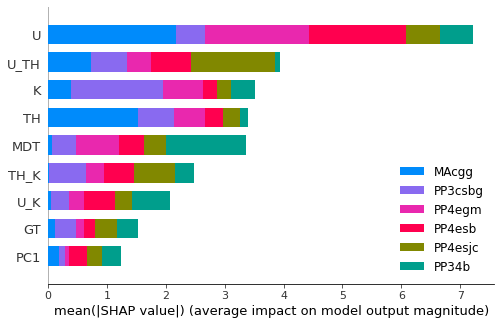

In [12]:
shap.summary_plot(shap_values, X_train_with_col_names, plot_type="bar", class_names = dic_lith, show=False)

plt.savefig("figures/notebook3/Figura_01.png", dpi = 300);

<p>
    <b>Figura 01:</b> Impacto das variáveis independentes nas predições do modelo <i>XGBoost</i>.
</p>

> Nota-se que, no geral, as features mais importantes são os canais radiométricos (i.e. `U`, `K` e `TH`) e a razão `U_TH`, enquanto `GT` e `PC1` exercem os menores impactos nas classificações.

> As variáveis independentes de maior impacto nas predições da unidade Complexo Granito-Gnáissico (MAcgg) foram `U` e `Th`.

> No caso da Formação Barão de Guaicuí (PP3csbg), `K` foi a feature mais importante.

> As predições das formações Bandeirinha (PP34b) e São João da Chapada (PP4esjc) foram mais influenciadas por `MDT` e pela razão `U_TH`, respectivamente.

> Nota-se que `U` é a variável de maior impacto nas predições das formações Sopa-Brumadinho (PP4esb) e Galho do Miguel (PP4egm).

### Summary plot

Os **summary plots** por unidade litoestratigráfica apresentados a seguir relacionam os valores das features (altos ou baixos) aos impactos (positivos ou negativos) nas predições realizadas pelo modelo *XGBoost*.

Valores de Shapley fortemente negativos indicam uma tendência maior de o modelo não predizer a classe em questão, ao passo que valores fortemente positivos favorecem a predição dessa unidade.

Assim como na *Figura 01*, as variáveis preditoras também são apresentadas em ordem crescente de importância (de baixo para cima).

#### Complexo Granito-Gnáissico (MAcgg)

A *Figura 02* apresenta o summary plot do Complexo Granito-Gnáissico.

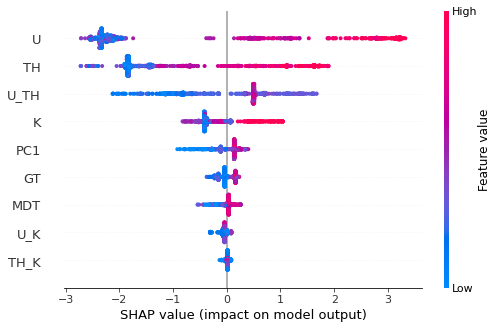

In [13]:
shap.summary_plot(shap_values[0],X_train_with_col_names, show=False)
    
plt.savefig("figures/notebook3/Figura_02.png", dpi = 300);

<p>
    <b>Figura 02:</b> Summary plot do Complexo Granito-Gnáissico.
</p>

> Valores altos de `U` e `TH` impactam positivamente na predição da unidade Complexo Granito-Gnáissico.

> As razões `U_K` e `TH_K` pouco contribuem para a classificação dessa unidade.

#### Formação Barão de Guaicuí (PP3csbg)

A *Figura 03* apresenta o summary plot da Formação Barão de Guaicuí.

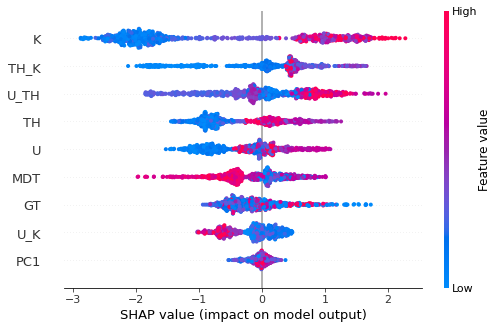

In [14]:
shap.summary_plot(shap_values[1],X_train_with_col_names, show=False)
    
plt.savefig("figures/notebook3/Figura_03.png", dpi = 300);

<p>
    <b>Figura 03:</b> Summary plot da Formação Barão de Guaicuí.
</p>

> `K` é a variável de maior importância na predição da Formação Barão de Guaicuí.

> Valores elevados de `K` favorecem a predição dessa unidade, enquanto valores baixos levam o modelo a não predizê-la.

> Valores elevados de `MDT` desfavorecem a predição dessa unidade.

#### Formação Bandeirinha (PP34b)

A *Figura 04* apresenta o summary plot da Formação Bandeirinha.

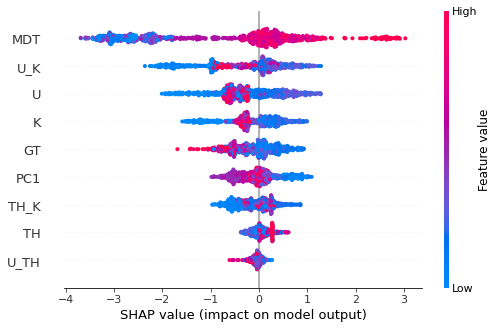

In [15]:
shap.summary_plot(shap_values[2],X_train_with_col_names, show=False)
    
plt.savefig("figures/notebook3/Figura_04.png", dpi = 300);

<p>
    <b>Figura 04:</b> Summary plot da Formação Bandeirinha.
</p>

> Altos valores de `MDT` impactam positivamente na predição da Formação Bandeirinha, enquanto valores baixos levam o modelo a não predizer essa unidade.

> `TH` e `U_TH` são as variáveis que menos influenciam na predição dessa classe.

#### Formação São João da Chapada (PP4esjc)

A *Figura 05* apresenta o summary plot da Formação São João da Chapada.

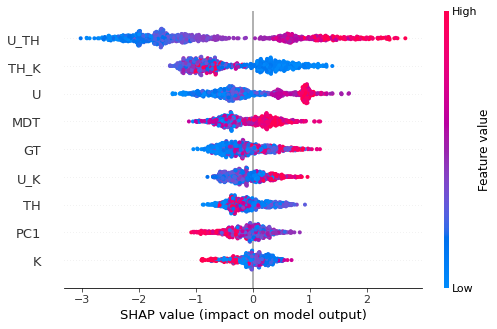

In [16]:
shap.summary_plot(shap_values[3],X_train_with_col_names, show=False)
    
plt.savefig("figures/notebook3/Figura_05.png", dpi = 300);

<p>
    <b>Figura 05:</b> Summary plot da Formação São João da Chapada.
</p>

> Elevados valores de `U_TH`, `MDT` e `U` favorecem a predição da Formação São João da Chapada, sendo a razão radiométrica a feature de maior impacto.

> Ao contrário do observado para a Formação Barão de Guaicuí, `K` é a variável de menor importância.

#### Formação Sopa-Brumadinho (PP4esb)

A *Figura 06* apresenta o summary plot da Formação Sopa-Brumadinho.

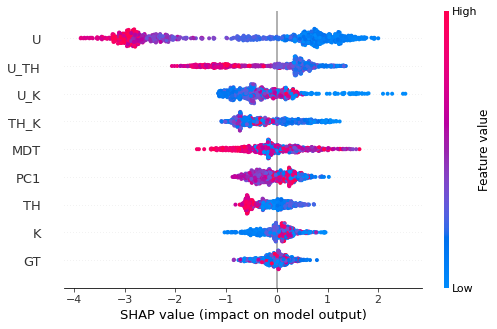

In [17]:
shap.summary_plot(shap_values[4],X_train_with_col_names, show=False)
    
plt.savefig("figures/notebook3/Figura_06.png", dpi = 300);

<p>
    <b>Figura 06:</b> Summary plot da Formação Sopa-Brumadinho.
</p>

> Valores baixos de `U` e `U_TH` levam o modelo a predizer a Formação Sopa-Brumadinho, ao passo que valores elevados dessas variáveis desfavorecem a classificação dessa unidade.

#### Formação Galho do Miguel (PP4egm)

A *Figura 07* apresenta o summary plot da Formação Galho do Miguel.

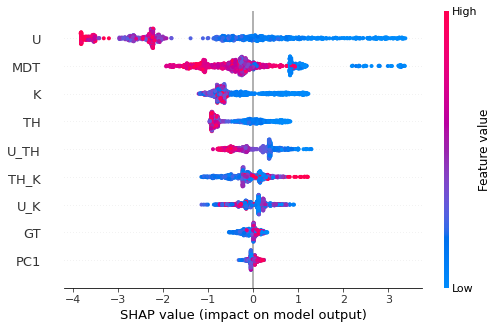

In [18]:
shap.summary_plot(shap_values[5],X_train_with_col_names, show=False)
    
plt.savefig("figures/notebook3/Figura_07.png", dpi = 300);

<p>
    <b>Figura 07:</b> Summary plot da Formação Galho do Miguel.
</p>

> Baixos valores dos canais radiométricos (i.e. `U`, `TH` e `K`) impactam positivamente na predição de uma instância como Formação Galho do Miguel.

> Valores muito baixos de `MDT` também levam o modelo a predizer essa unidade.